# Clustering and Visualization of Phoebe dataset

## Components
* Create dataset with every row linked to the image it was generated from

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
DATASET_FILE = "Phoebe_dataset4.zip"
full_path = os.path.abspath(DATASET_FILE[:-4])
if not os.path.exists(full_path):
    !unzip -o $DATASET_FILE;

<module 'logging' from '/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.7/lib/python3.7/logging/__init__.py'>

---
## Preparation

### ETL helpers

In [39]:
# import os, os.path
from typing import List, Dict, Union, Any
import csv
import uuid
import re
import time
import datetime
import logging

# Paths
PATH_DATASET = "Phoebe_dataset4"
PATH_AU_INTENSITY = "single_person_au_intensity"
PATH_AU_PRESENCE = "single_person_au_presence"
PATH_TRAIN = "train"
PATH_TEST = "test"
PATH_TRAINING_VIDEOS = PATH_DATASET + "/videos/train"
PATH_TESTING_VIDEOS = PATH_DATASET + "/videos/test"
PATH_PROCESSED_IMAGES = PATH_DATASET + "/processed_images"
PATH_TRAINING_CSV = f"./{PATH_DATASET}/{PATH_AU_INTENSITY}/{PATH_TRAIN}/"
PATH_TESTING_CSV = f"./{PATH_DATASET}/{PATH_AU_INTENSITY}/{PATH_TEST}/"


# General
EXT_MP4 = "mp4"

# Stores
IMAGE_STORE = {}

log = logging.getLogger()
log.setLevel(logging.ERROR)

if not os.path.isdir(PATH_PROCESSED_IMAGES):
    os.mkdir(PATH_PROCESSED_IMAGES)

In [40]:
import queue

AU_FEATURES_FIRST_INDEX = 5


def temporal_smoothing(lst):
    # print(lst)
    # Current represents the original value currently being modified
    current = lst[-1]
    
    if len(lst) == 1:
        return lst[0]
    
    avg = sum(lst) / len(lst)
    
    new_val = (2 / 3) * current + (1 / 3) * avg
    return round(new_val, 2)

def load_dataset(filename: str, train: bool) -> List[Union[str, float]]:
    """Load dataset for a single csv/video pair.
    
    :param filename: name of video and csv without an extension.
    
    :return: result dataset for csv/video pair.
    """
    # Load csv with python library so that first column may be removed.
    # print(filename)
    raw_data = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        
        # temporal_queue is a list of queue to temporally smooth out every AU along the time axis
        temporal_queue: List[Any] = [[] for i in range(0, 17)]
          
        for index, row in enumerate(reader):
            if index == 0:
                row = [x.strip() for x in row]
                # Rename column row
                row[0] = "frame"
                
                # Create a new column to save filename the row came from.
                # This is used to extract image when needed (filename + frame are needed)
                row.insert(0, "filename")
                
            elif row[0] != "":
                # Create an image for every row and add to dictionnary {id: path}
                filename_without_ext: str = re.findall(r"[0-9]+", filename)[-1]
                row.insert(0, filename_without_ext)
                
                # Increment frame number by 1 to start at index 1 (images get produced starting at index 1)
                row[1] = int(row[1]) + 1
                
                # Change all AU values to floats
                for au_index, au_str in enumerate(row[AU_FEATURES_FIRST_INDEX:]):
                    row[AU_FEATURES_FIRST_INDEX + au_index] = float(au_str)
                    
                # print(f"Before: \t{row[AU_FEATURES_FIRST_INDEX:]}") # For debugging
                # For every AU column, have a moving window to temporally smooth our AU values
                for i, val in enumerate(row[AU_FEATURES_FIRST_INDEX:]):
                    # There are 'i' temporal queues to hold data points for 'i' AU features.
                    temporal_queue[i].append(val)

                    # Perform smoothing
                    row[i + AU_FEATURES_FIRST_INDEX] = temporal_smoothing(temporal_queue[i])
                    
                    if len(temporal_queue[i]) >= 3:
                        temporal_queue[i].pop(0)
                # print(f"After: \t\t{row[AU_FEATURES_FIRST_INDEX:]}\n") # For debugging
                    
            raw_data.append(row)
            
        # Extract all images of corresponding video
        extract_all_images_from_video(raw_data[1], train)
        
        # Remove all rows that have no associated image
        final_data = [raw_data[0]]
        for i in raw_data[1:]:
            image = image_path_for_row(i)
            if image:
                final_data.append(i)
    
    return final_data

def create_full_dataset(training_files, train=True) -> List[Union[str, float]]:
    """Load dataset for every csv/video pair.
    
    :param training_files: list of csv files.
    
    :return: full dataset results
    """
    assert(isinstance(training_files, list)) 
    full_dataset = []
    for file in training_files:
        dataset = load_dataset(file, train)
        if len(full_dataset) == 0:
            full_dataset = dataset
        else:
            full_dataset.extend(dataset[1:])
    return full_dataset

### Images helpers
If image has not been extracted for given id, extract it from corresponding video. This is made easy because the matrix stores the video name (without the extension) and the frame number.

Pass the entire row of data to the `extract_image_for_frame` function in order to get the correct frame.

In [41]:
from IPython.display import display, Image
import datetime
import subprocess

FRAME_RATE = 1/34

def get_length(filename):
    """Get length of a video file."""
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

def get_video_path(video_name, train):
    """Return video filepath
    :param video_name:
    :param train: whether this is a training or testing set
    """
    if train:
        return PATH_TRAINING_VIDEOS + f"/{video_name}.{EXT_MP4}"
    else:
        return PATH_TESTING_VIDEOS + f"/{video_name}.{EXT_MP4}"
    
def extract_all_images_from_video(row: List[Any], train):
    video_name = int(row[0])
    image_name = f"{video_name:03}"
    image_path = PATH_PROCESSED_IMAGES + "/" + image_name
    video_filepath = get_video_path(video_name, train)
    
    command = f"ffmpeg -i {video_filepath} {image_path}%3d.jpeg -n"
    print(f"Running command: {command}")
    !$command;

# %%capture
# def extract_image_for_frame(image_path: str, video_name: str, frame: str, train=True):
#     """Extracts a frame from a video given a timestamp in seconds.
    
#     :param orig_filename: name of video for which timestamp applies
#     :param row_id: id of row and image
#     :param train: whether the image is for the training or testing dataset

#     :return: name of the image without its extension.
#     """
#     video_filepath = get_video_path(video_name, train)
    
#     # Data was sampled at about 30fps. Get time at which it is in the video
#     time_in_seconds = round(FRAME_RATE * frame, 3)
    
# #     print(time_in_seconds)
# #     print(get_length(video_filepath))
# #     print(f"frame is {frame}")
#     # assert(time_in_seconds < get_length(video_filepath))
#     # time_datetime = datetime.timedelta(seconds=time_in_seconds)
    
#     # Find frame closest to time. 
#     # -ss must come after -i or it will sometimes break. See here https://tinyurl.com/y9hnppm7
#     command = f"ffmpeg  -noaccurate_seek -i {video_filepath} -ss {time_in_seconds} -vframes 1 {image_path} -n"
#     print(f"Running command: {command}")
    
#     # Run CLI command
#     !$command;

def image_path_for_row(row: List[Any]):
    """Return path of image for a row
    
    :param row: a row of data
    """
    video_name = int(row[0])
    frame = int(row[1])
    image_name = f"{video_name:03}{frame:03}"
    image_path = PATH_PROCESSED_IMAGES + "/" + image_name + ".jpeg"
    if not os.path.exists(image_path):
        print("NO IMAGE FOR THIS ROW")
        return ""
    return image_path
    
def show_image_from_row(row: List[Any], train=True):
    """
    :param row: a row of data from full_dataset (a python list which contains the header). This
        is a bit ugly, but it is the way I started it.
    :param train: whether the image is for the training or testing dataset
    """
    # log.debug(f"### Getting image for row: {row}")
    
    image_path = image_path_for_row(row)
    
    try:
        image = Image(filename=f'{image_path}')
        display(image)
    except IOError as e:
        print(e)      

### Run dataset preparation pipeline

In [42]:
%%capture
training_files: List[str] = [f"{PATH_TRAINING_CSV}{name}" for 
                             name in os.listdir(f"{PATH_TRAINING_CSV}") if 
                             name[-4:] == ".csv"]

# print(training_files[0:2])

# Load datasets
full_dataset = create_full_dataset(training_files)

In [43]:
count = 3
print(f"First {count} rows of dataset:\n")
for i in range(0, count):
    print(str(full_dataset[i]) + "\n")

First 3 rows of dataset:

['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

['6', 1, '0', '0.98', '1', 0.11, 0.0, 0.0, 0.0, 1.33, 2.09, 0.0, 1.1, 1.62, 0.08, 0.1, 0.15, 0.0, 0.0, 0.0, 0.29, 0.0]

['6', 2, '0', '0.98', '1', 0.05, 0.0, 0.11, 0.07, 1.4, 2.18, 0.11, 1.13, 1.61, 0.04, 0.13, 0.36, 0.0, 0.0, 0.1, 0.13, 0.01]



---
## Preprocess and cleanup data
- [X] Remove rows with confidence < 85
- [X] Remove rows with empty value(s)
- [X] Temporally smooth out AU values (done earlier)
- [X] Scale AU values in [0, 1]

In [44]:
from pprint import pprint

CONFIDENCE_LEVEL = 0.85

full_dataset_header = full_dataset[0]
print(full_dataset_header)
index_to_key = {i: j for i, j in enumerate(full_dataset_header)}
keys_full_dataset = {j: i for i, j in enumerate(full_dataset_header)}

def preprocess(full_dataset):

    # NOTE: because full_dataset stores strings in the first row, it must be skipped
    # in list comprehensions. Furthermore, the strings also need to be cast to whatever
    # format they are being compared to (int, float).
    
    # Preserve the header
    cleaned_dataset = []
    
    removed_non_success = 0
    removed_low_confidence = 0
    removed_wrong_face_id = 0
    
    # Do NOT keep the header. We only want numbers in this array (int, float)
    for row in full_dataset[1:]:
        valid = {
            "success": True,
            "confidence": True,
            "face_id": True
        }

        # We only want rows with success = 1
        if int(row[keys_full_dataset["success"]]) == 0:
            valid["success"] = False
            removed_non_success += 1
        
        if float(row[keys_full_dataset["confidence"]]) < CONFIDENCE_LEVEL:
            valid["confidence"] = False
            removed_low_confidence += 1
            
        if int(row[keys_full_dataset["face_id"]]) != 0:
            valid["face_id"] = False
            removed_wrong_face_id += 1
        
        # Add this row if all keys in the criteria dict are set to True
        if all(value for value in valid.values()):
            cleaned_dataset.append(row)
            
    print(f"Removed {removed_non_success} rows with 'success = 0'")
    print(f"Removed {removed_low_confidence} rows with 'confidence <= {CONFIDENCE_LEVEL}'")
    print(f"Removed {removed_wrong_face_id} rows with wrong face id (not Phoebe)")
          
#     full_dataset_all_success = [x for x in full_dataset[1:] 
#                                 if int(x[keys_full_dataset["success"]]) == 1]
#     print("Removed {} rows with 'success = 0'".format(
#         len(full_dataset) - len(full_dataset_all_success)))

#     # Only keep rows that have "confidence > 0.85"
#     full_dataset_good_confidence = [x for x in full_dataset_all_success[1:] 
#                                     if float(x[keys_full_dataset["confidence"]]) >= CONFIDENCE_LEVEL]
#     print("Removed {} rows with 'confidence < {}'".format(
#         len(full_dataset_all_success) - len(full_dataset_good_confidence), CONFIDENCE_LEVEL))

    return cleaned_dataset

# Do not edit final_dataset. It is there to keep indempotency in case more filters
# need to be added above. The final dataset has all unwanted rows removed, but still
# has the header row.
final_dataset = preprocess(full_dataset)

['filename', 'frame', 'face_id', 'confidence', 'success', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']
Removed 85 rows with 'success = 0'
Removed 127 rows with 'confidence <= 0.85'
Removed 0 rows with wrong face id (not Phoebe)


### Scale AU in [0, 1]

In [45]:
from sklearn import preprocessing
import numpy as np

def scaled_AU_np_dataset(final_dataset):
    only_AU_info = [x[keys_full_dataset["AU01_r"]:] 
                    for x in final_dataset[1:]]
    
    X_train = np.array(only_AU_info, dtype=float)

    # Scale AUs
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_train = min_max_scaler.fit_transform(X_train)
    # Confirm only the 17 AU are there
    assert(X_train.shape[1] == 17)
    
    return X_train

X_train = scaled_AU_np_dataset(final_dataset)
# np.savetxt(f'data{uuid.uuid4()}.csv', X_train, delimiter=',')

### Show image from index

In [46]:
def image_path_from_index(index: int, train=True):
    # full_dataset/final_dataset has +1 row than numpy array index was pulled from
    path = image_path_for_row(final_dataset[index + 1])
    return path

---
## Gausian Mixture Model

### First GMM

In [55]:
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

def plot_gmm(n_components, ax=None):
    ax = ax or plt.gca()
    
    gmm = GMM(n_components).fit(X_train)
    probs = gmm.predict_proba(X_train) 
    count = 3
    print(f"First {count} trained rows of probabilities table: \n{probs[:count].round(3)}")

    # Print maximum probability for every row. The closest it is to 1, the more
    # certain GMM is about that point (=row).
    count = 100
    maxInRows = np.amax(probs, axis=1)
    print(f"Max probability value of any category for {count} row: \n{maxInRows[:count]}")


    labels = gmm.predict(X_train)
    size = 50 * probs.max(1) ** 2 # square emphasizes differences
    plt.figure(figsize=(14,14))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=size, cmap='viridis');

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

First 3 rows of X_train:
[0.02 0.   0.03 0.04 0.42 0.53 0.07 0.36 0.51 0.01 0.03 0.07 0.   0.
 0.03 0.03 0.  ]

[0.01 0.   0.03 0.04 0.42 0.5  0.07 0.33 0.49 0.01 0.02 0.07 0.09 0.
 0.06 0.04 0.05]

[0.   0.   0.03 0.08 0.43 0.46 0.05 0.29 0.45 0.01 0.01 0.04 0.11 0.02
 0.05 0.06 0.12]

First 3 trained rows of probabilities table: 
[[0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.01 0.  ]]
Max probability value of any category for 100 row: 
[1.   1.   0.99 0.91 0.88 0.99 0.99 0.69 1.   0.97 0.71 1.   1.   0.99
 0.96 0.73 0.96 1.   1.   1.   0.98 0.91 1.   1.   0.97 0.94 1.   0.97
 0.99 1.   1.   0.63 0.97 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.99 1.
 1.   1.   0.97 1.   1.   1.   1.   1.   0.98 1.   1.   1.   0.67 0.9

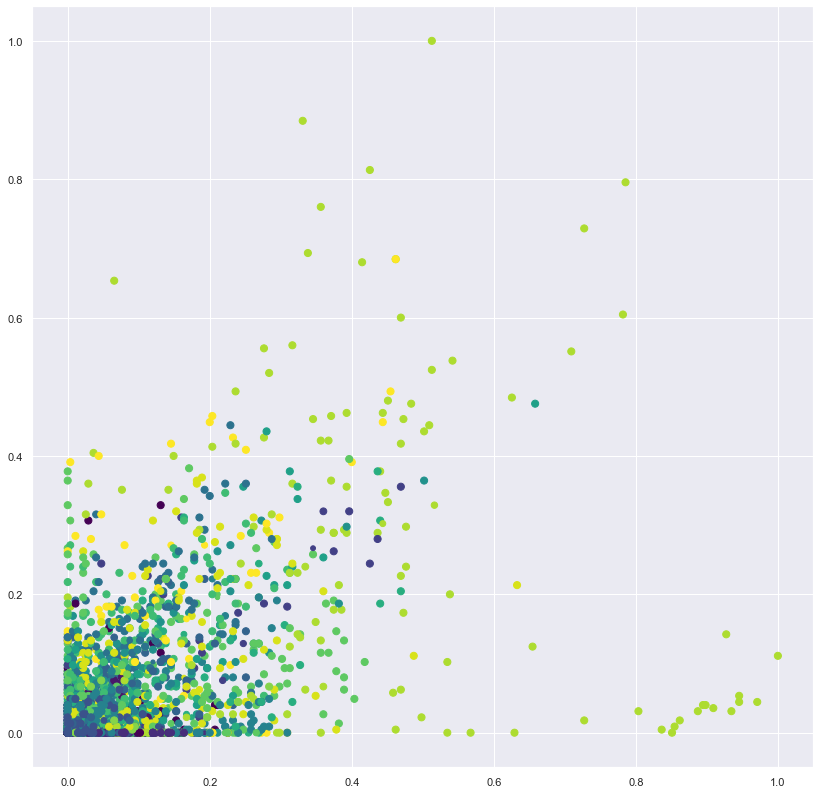

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.mixture import GaussianMixture as GMM

count = 3
print(f"First {count} rows of X_train:")
for i in range(0, count):
    print(str(X_train[i]) + "\n")

X_train_with_labels = X_train

# gmm = GMM(n_components=17).fit(X_train)
# probs = gmm.predict_proba(X_train) 
# count = 3
# print(f"First {count} trained rows of probabilities table: \n{probs[:count].round(3)}")

# # Print maximum probability for every row. The closest it is to 1, the more
# # certain GMM is about that point (=row).
# count = 100
# maxInRows = np.amax(probs, axis=1)
# print(f"Max probability value of any category for {count} row: \n{maxInRows[:count]}")


# labels = gmm.predict(X_train)
# size = 50 * probs.max(1) ** 2 # square emphasizes differences
# plt.figure(figsize=(14,14))
# plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=size, cmap='viridis');
plot_gmm(X_train)

The current GMM does not show any clear blobs. Rather, the data seems to be scattered heterogeneously. However, I can see in the probabilities for individual points that each point has a high probability of belonging to a single cluster. Therefore, I think that the high level of dimensions of the data is problematic.

### Optimal number of components

/Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/leo/workspace/cmpt419/CMPT419-A2/venv/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


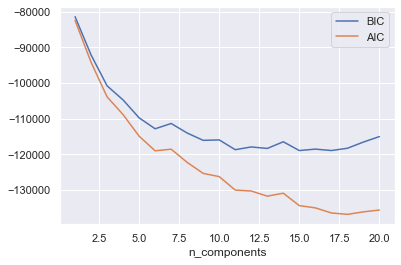

In [49]:
# Turn off DEBUG logs otherwise the below graph fills the logs...
logging.basicConfig(level=logging.ERROR)

n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X_train)
          for n in n_components]
plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC') 
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC') 
plt.legend(loc='best')
plt.xlabel('n_components');

The best number of components is about 17. This makes sense since there are 17 parameters in the training data.

### Most representative image per component

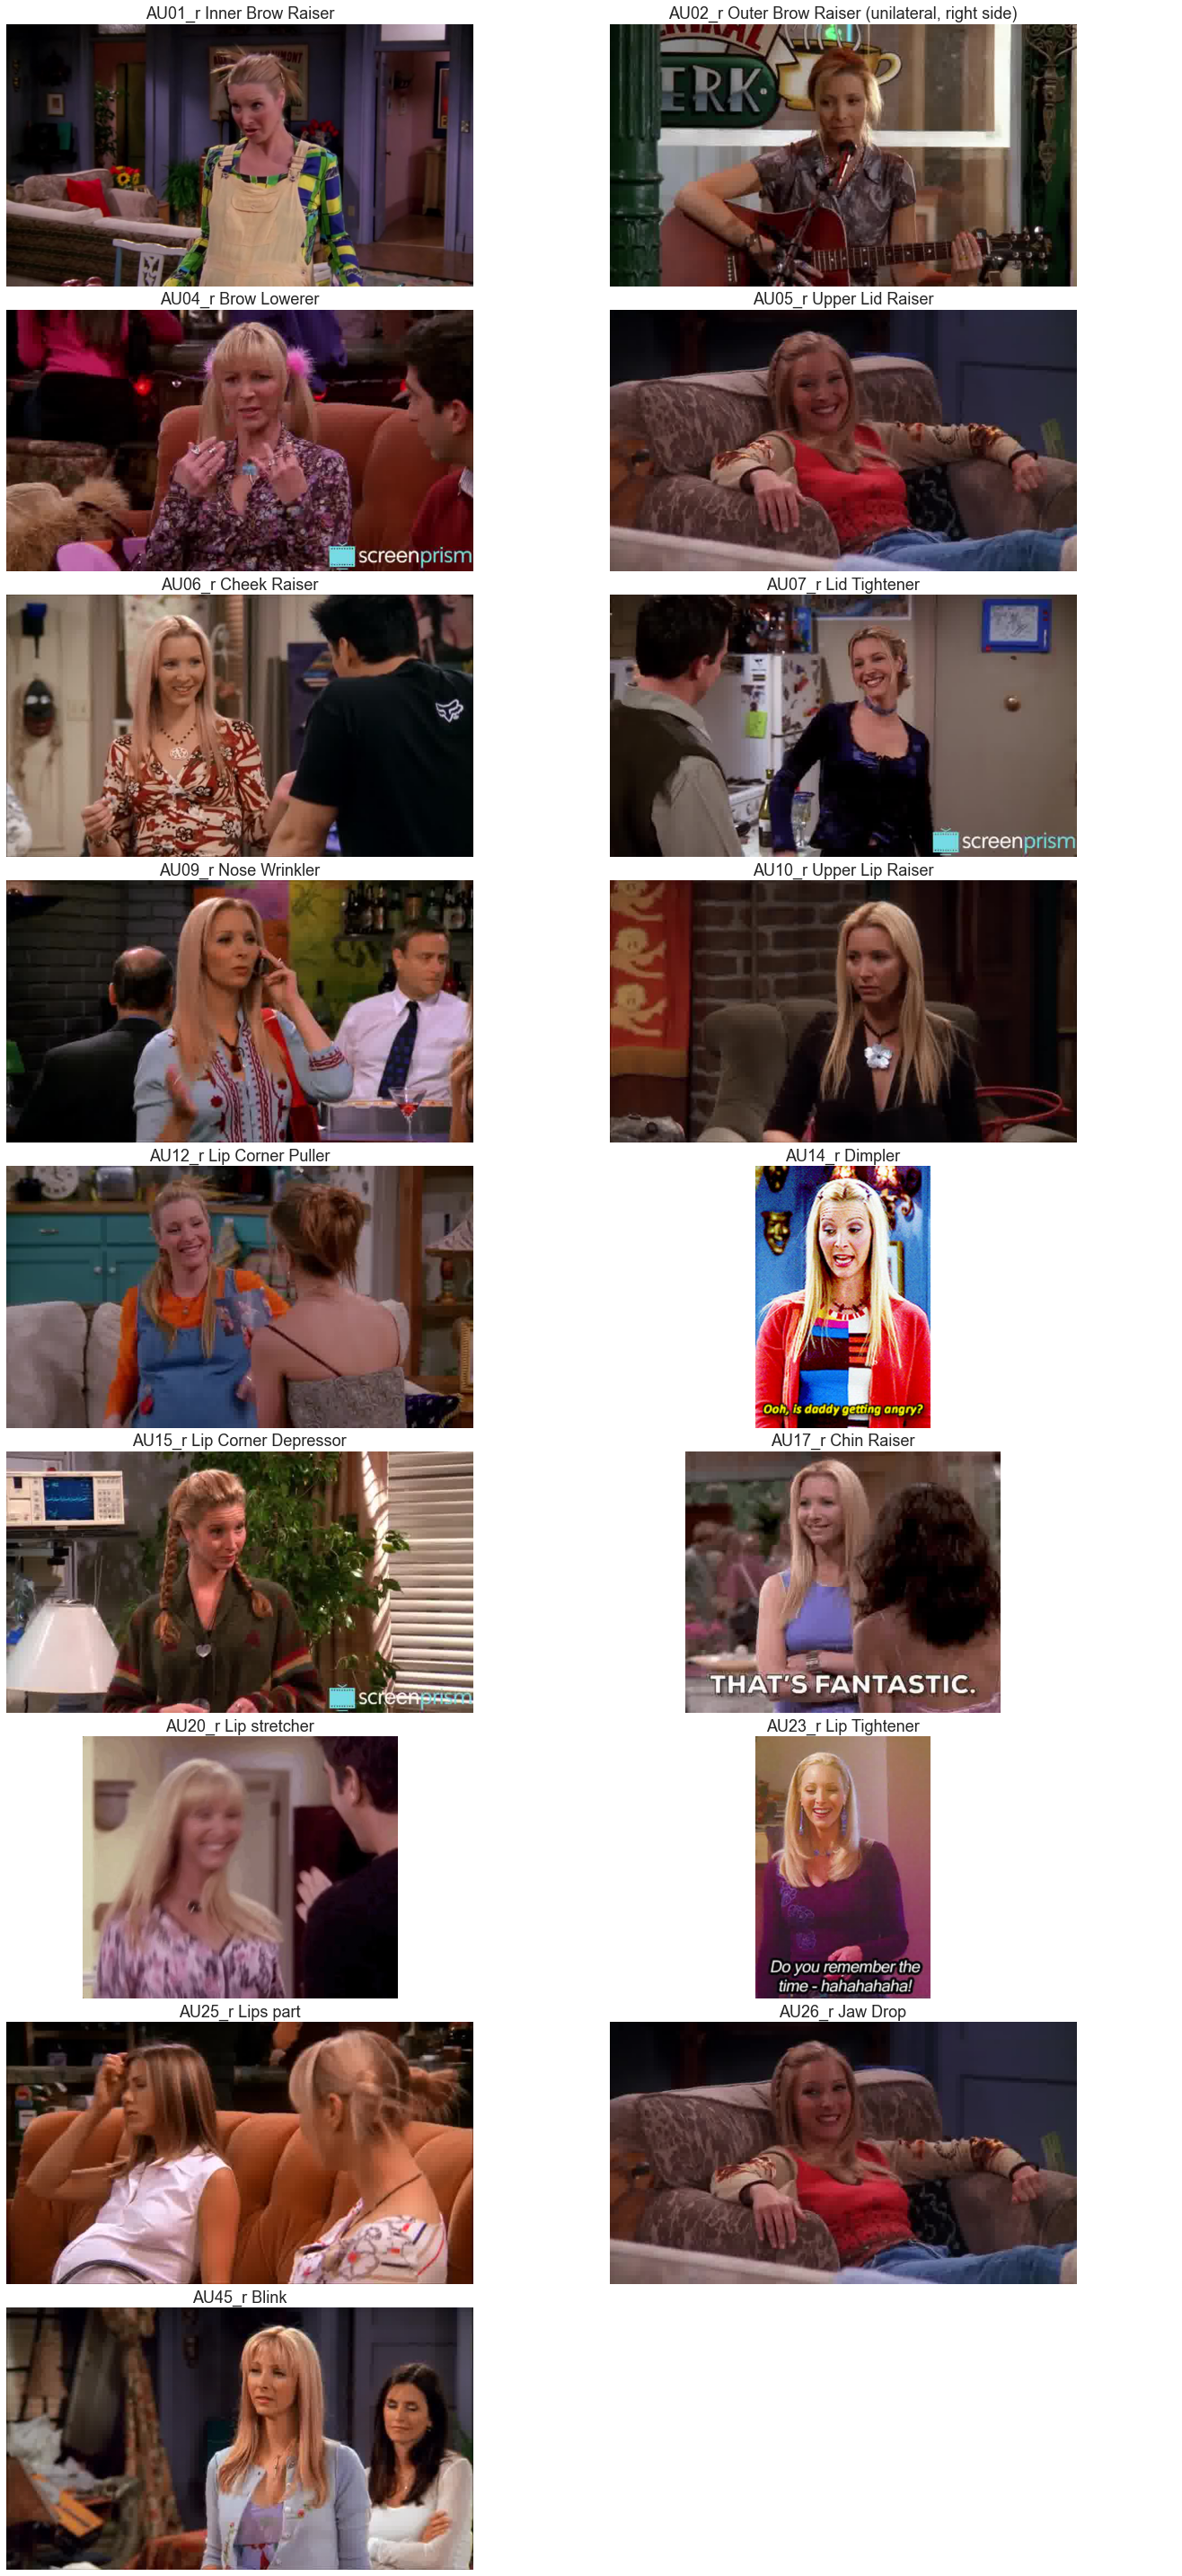

In [50]:
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

# AU to descriptor dict
AU_DESCRIPTOR = {
    "AU01": "Inner Brow Raiser",
    "AU02": "Outer Brow Raiser (unilateral, right side)",
    "AU04": "Brow Lowerer",
    "AU05": "Upper Lid Raiser",
    "AU06": "Cheek Raiser",
    "AU07": "Lid Tightener",
    "AU09": "Nose Wrinkler",
    "AU10": "Upper Lip Raiser",
    "AU12": "Lip Corner Puller",
    "AU14": "Dimpler",
    "AU15": "Lip Corner Depressor",
    "AU17": "Chin Raiser",
    "AU20": "Lip stretcher",
    "AU23": "Lip Tightener",
    "AU25": "Lips part",
    "AU26": "Jaw Drop",
    "AU45": "Blink",
}

# Turn off DEBUG logs otherwise the below graph fills the logs...
# logging.basicConfig(level=logging.DEBUG)

def present_data(gmm, X_matrix):
    """For each category (aka column), present the row's images and 
    metadata which have the highest probability of being in that category.
    
    :param gmm: the Gaussian Mixture Model to use
    :param X_matrix: the dataset to use for the GMM
    """
    
    # Gaussian probabilities for every row of data
    probs = gmm.predict_proba(X_matrix) 
    
    # Find the row index of the highest value for every column. The row index can be linked back to its image.
    maxval = np.max(probs, axis=0)
    log.debug(f"Max values for the columns: {maxval}\n")

    # Transform to panda dataframe to find rows with highest value for each category
    probs_pd = pd.DataFrame(probs)

    # [AU_num, row_num]
    indices: List[Tuple[int]] = []

    for i in range (0, 17):
        indices.append((i, probs_pd[i].argmax()))
    log.debug(f"Tuple (AU_num, row_num) for max value of every AU column: \n{indices}\n")

    # To access key name from dictionary, account for 5 deleted columns that precede AU columns
    ACCOUNT_FOR_5_MISSING_HEADER_COLS = 5
    # Show image for every AU

    def get_row_metadata(row_index: int):
        """Return probabilities for each class"""
        # Get row from probability matrix

        row_X = X_matrix[row_index]
        row_probs = probs[row_index,]
        np.set_printoptions(precision=2)
        np.set_printoptions(suppress=True)
        log.debug(f"ROW_X: \t\t{row_X}")
        log.debug(f"ROW_probs: \t{row_probs}")

    fig, ax_array = plt.subplots(int(len(indices)/2) + 1, 2, figsize=(20,40))
    axes = ax_array.flatten()
    
    for i, ax in enumerate(axes):
        try:
            metadata = get_row_metadata(indices[i][1])
            AU_type = index_to_key[indices[i][0] + ACCOUNT_FOR_5_MISSING_HEADER_COLS]
            title = AU_type + " " + AU_DESCRIPTOR[AU_type[:4]]
            img_path = image_path_from_index(indices[i][1])
            ax.set_title(title, fontsize=18)
            ax.axis('off')
            ax.grid(b=None)
            img=mpimg.imread(img_path)
            ax.imshow(img)
        except IndexError:
            pass
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0.5, w_pad=0.01)
    plt.savefig(f'AU_illustrations.png')

plot = present_data(gmm, X_train)

The images and data rows for AU26 and AU45 show that they have different AU levels despite being almost the same. 
One way to circumvent this issue could be make every AU change less rapidly between time connected points. I guess that I am here talking about doing a temporal normalization on every AU.

## UMAP
Reduce dimensions of the dataset.

In [51]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

### Plot dimension pairs
Plotting pairs of dimensions show whether they tend to occur together or not

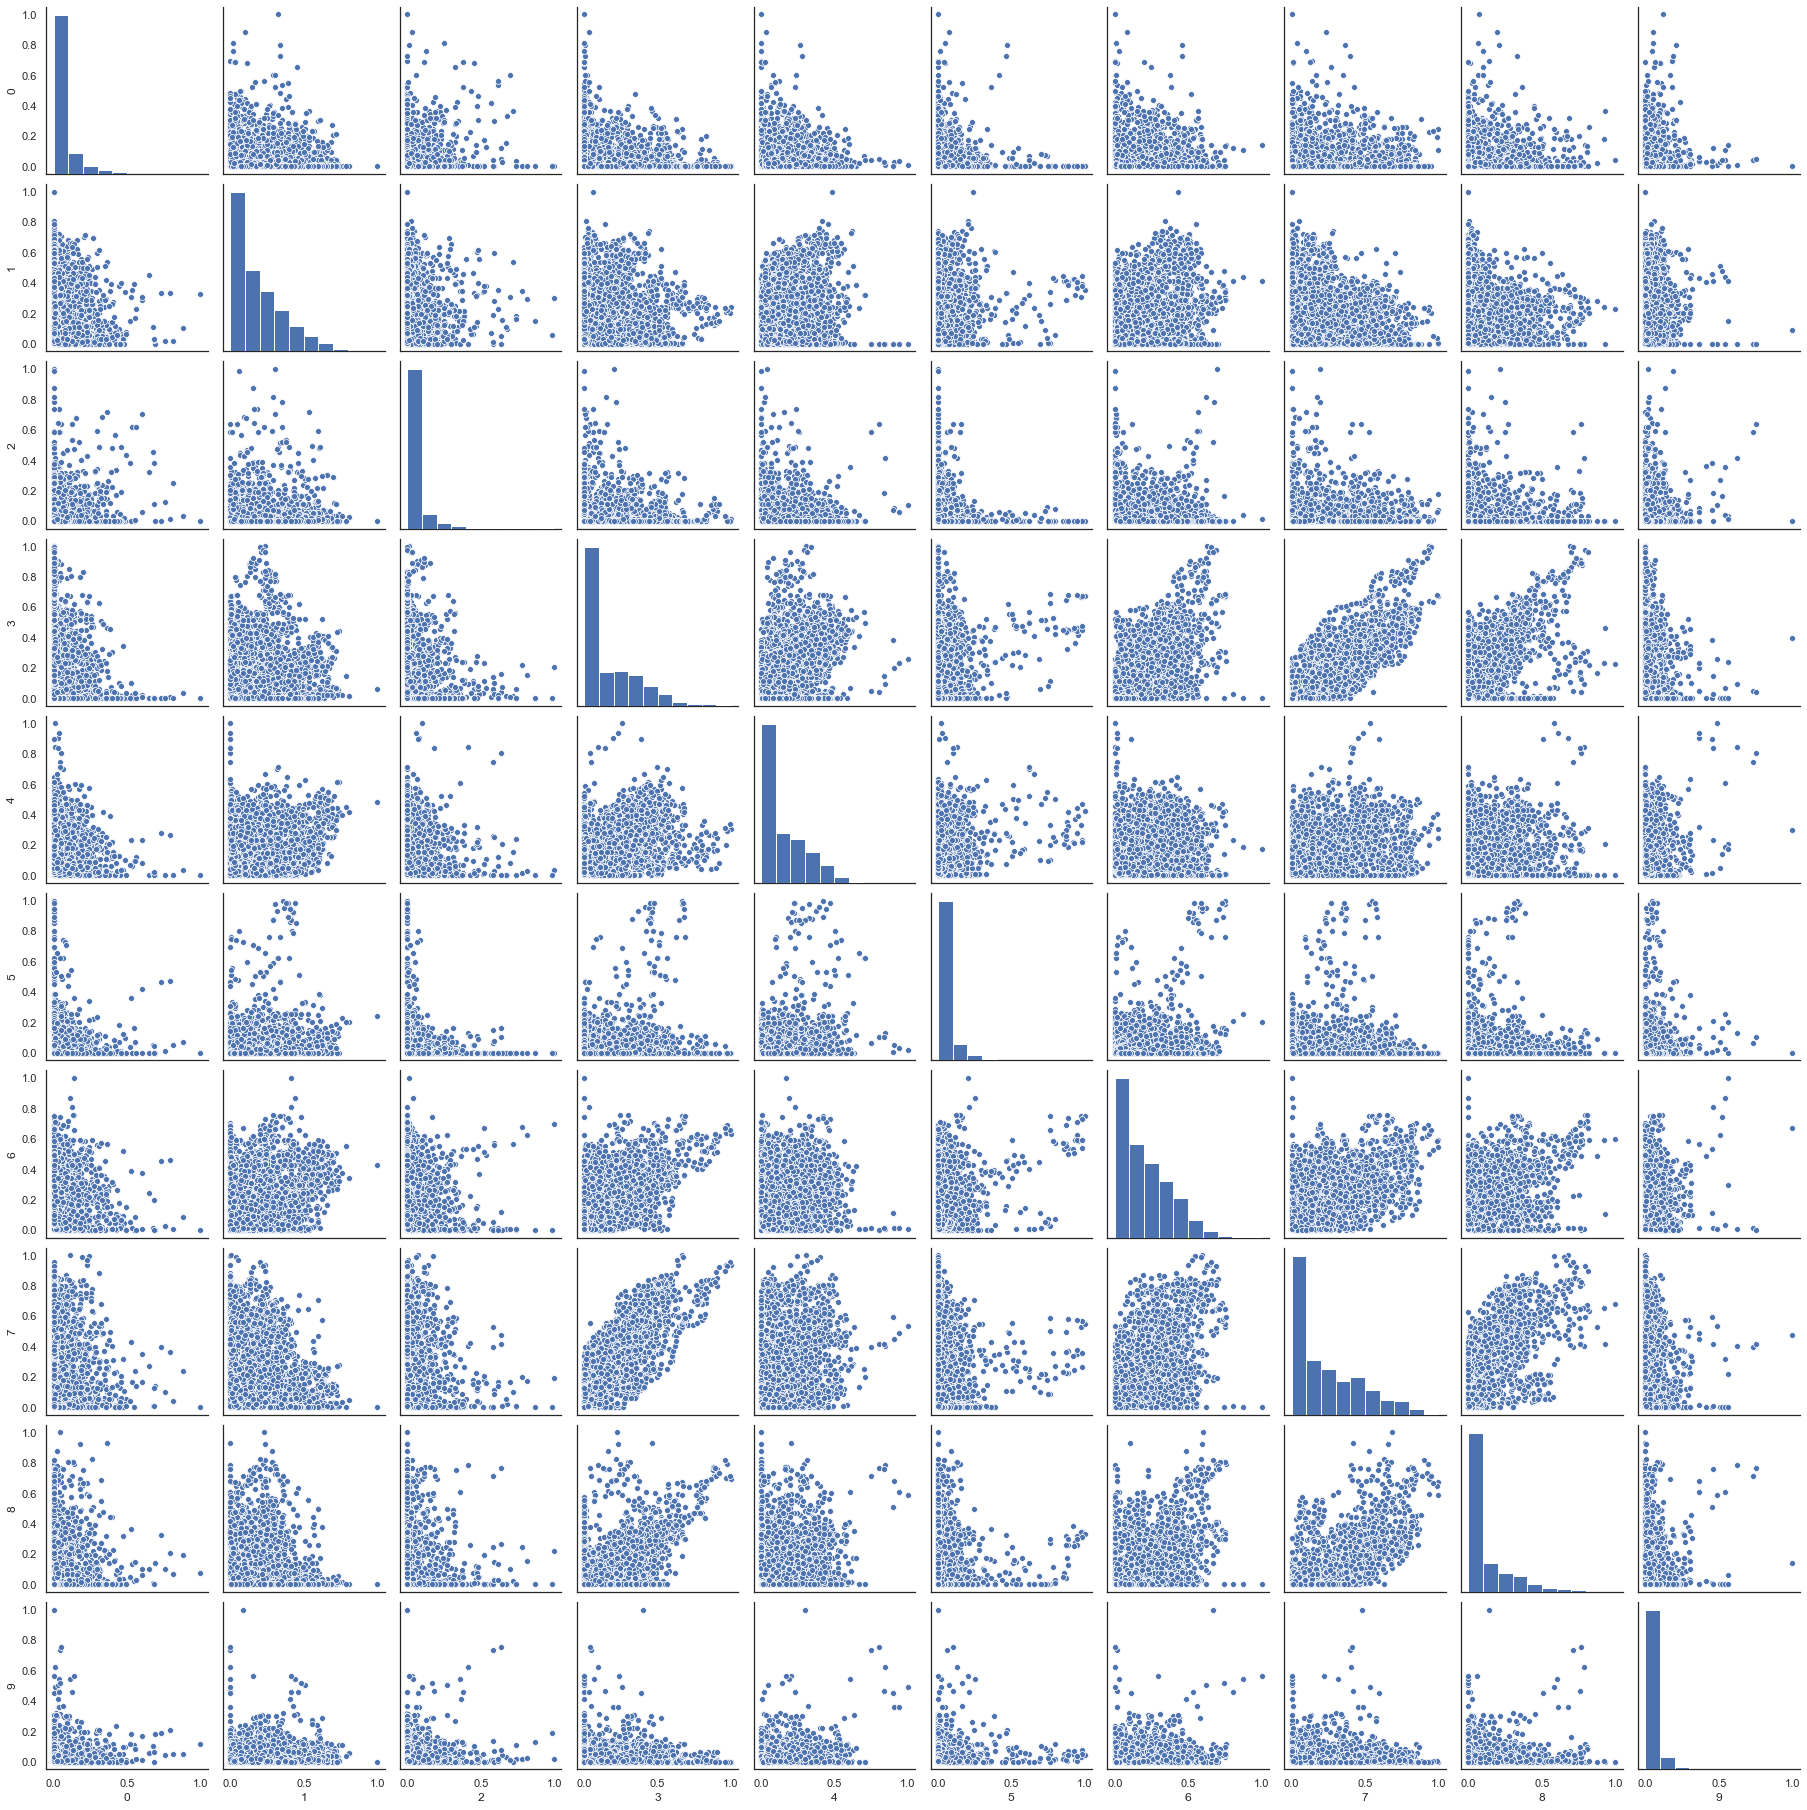

In [52]:
# Plot first 5 dimensions without UMAP
X_train_df = pd.DataFrame(X_train[:,1:11]) 
sns.pairplot(X_train_df)

In [53]:
# %%capture
logging.basicConfig(level=logging.ERROR)

import umap

reducer = umap.UMAP(random_state=42)
reducer.fit(X_train)
embedding = reducer.transform(X_train)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

print(embedding[0:4])

UMAP(random_state=42)

(3086, 2)

[[2.52 3.28]
 [2.5  3.29]
 [2.59 3.32]
 [2.6  3.32]]


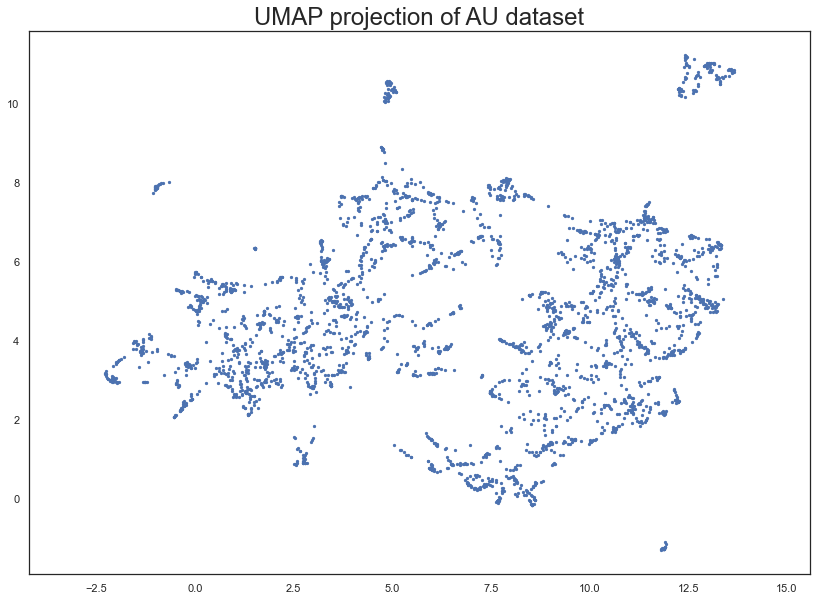

In [54]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of AU dataset', fontsize=24);

### Best number of components

Since the result for each run is non-deterministic, let's consider the result an mean standard deviation.

TODO:
* Splice the main dataset into 3 different datasets. On all, find the best number of components. We will measure two things:
    * The average distance between a point in a cluster and all other points in that cluster
    * The average distance between a point in a cluster and all other points in the next nearest cluster.

We are effectively measuring how close the close points are, and how apart different points are.
We want to have the biggest number of clusters that are also stable.

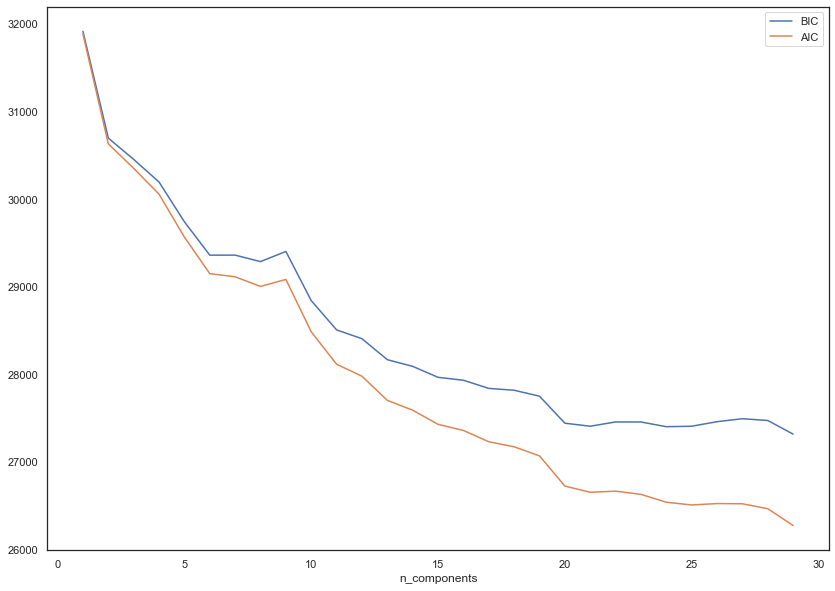

In [19]:
n_components = np.arange(1, 30)
models = [GMM(n, covariance_type='full', random_state=0).fit(embedding)
          for n in n_components]
plt.plot(n_components, [m.bic(embedding) for m in models], label='BIC') 
plt.plot(n_components, [m.aic(embedding) for m in models], label='AIC') 
plt.legend(loc='best')
plt.xlabel('n_components');

### GMM on UMAP data

Max probability value of any category for first 100 row: 
[1.   0.98 1.   1.   0.95 1.   0.93 1.   0.78 1.   0.99 1.   1.   1.
 1.   0.98 0.68 0.93 0.97 0.97 1.   0.97 1.   0.99 0.99 1.   1.   1.
 1.   0.54 1.   1.   1.   1.   1.   1.   0.96 1.   1.   1.   0.99 0.99
 1.   1.   1.   0.88 0.99 0.82 1.   1.   1.   1.   1.   1.   1.   0.97
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.75 0.97
 1.   1.   1.   1.   0.99 1.   1.   1.   1.   0.99 1.   1.   1.   1.
 1.   1.   1.   0.6  1.   1.   1.   0.97 0.96 0.89 0.92 0.9  0.98 0.99
 1.   1.  ]


<Figure size 1008x1008 with 0 Axes>

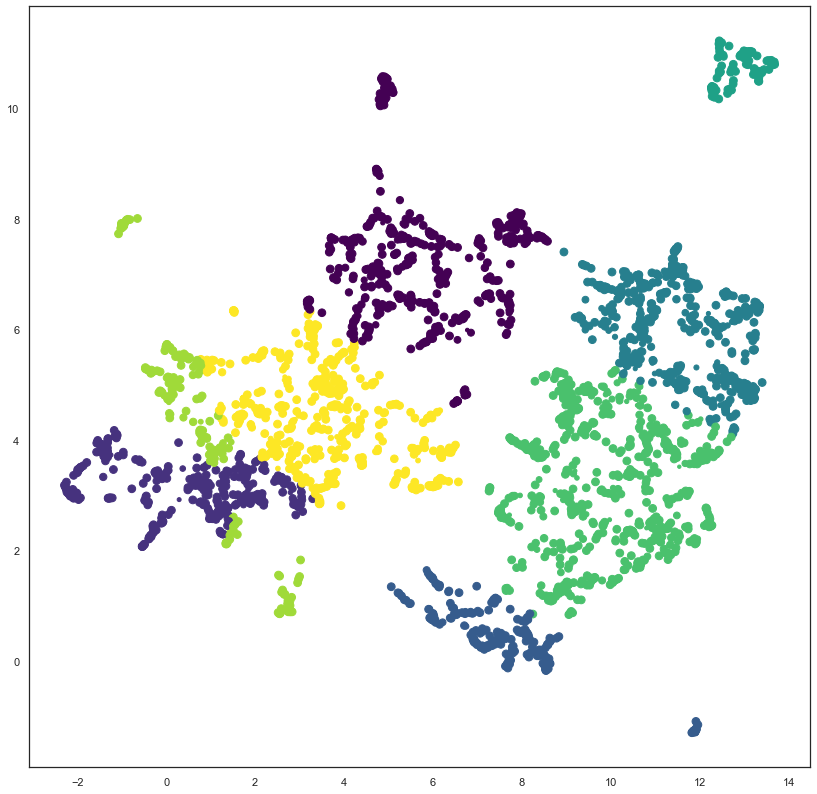

In [20]:
now = datetime.datetime.now()
RUN_ID = now.strftime("%Y-%m-%d %H:%M:%S")
NUM_COMPONENTS = 8

gmm = GMM(n_components=NUM_COMPONENTS, n_init=5, random_state=1).fit(embedding)

# Print maximum probability for every row. The closest it is to 1, the more
# certain GMM is about that point (=row).
count = 100
maxInRows = np.amax(probs, axis=1)
print(f"Max probability value of any category for first {count} row: \n{maxInRows[:count]}")


labels = gmm.predict(embedding)
size = 60 * probs.max(1) ** 2 # exponent emphasizes differences
plt.figure(figsize=(14,14))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=size, cmap='viridis');
plt.savefig(f'scatterplot_{RUN_ID}.png')

In [21]:
# Gaussian probabilities for every row of data
probs = gmm.predict_proba(embedding) 

# Print probability for some rows
print(probs[100:105])

[[0.   0.16 0.   0.   0.   0.   0.   0.84]
 [0.   0.14 0.   0.   0.   0.   0.   0.86]
 [0.   0.43 0.   0.   0.   0.   0.27 0.3 ]
 [0.   0.67 0.   0.   0.   0.   0.21 0.11]
 [0.   0.69 0.   0.   0.   0.   0.19 0.12]]


In [22]:
# Let's try an interactive graph that gives the probabilities of each category for each point
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [23]:
# %%capture
x = embedding[:, 0]
y = embedding[:, 1]
colors = labels # Repeat just for clarity (from previous cell)

source = ColumnDataSource(data=dict(
    x=x[:3000], 
    y=y[:3000], 
    #colors=colors,
    imgs=[image_path_from_index(i) for i in range(1, len(y))][:3000],
    probs=[probs[i].round(3) for i in range(0, len(y))][:3000])
)
print(f"len(y): {len(y)}")

size = 10 * probs.max(1) ** 2 # exponent emphasizes differences

TOOLTIPS = """
    <div>
        <div>
            <img
                src="data:image/jpeg;base64, file://@imgs" height="30px" width="30px"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 15px;">Probabilities</span>
            <span style="font-size: 10px; color: #696;">@probs</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;">($x, $y)</span>
        </div>
    </div>
"""

p = figure(
    title='UMAP projection of the AU data',
    plot_width=1000, 
    plot_height=1000,
    tools=('pan, wheel_zoom, reset'),
    tooltips=TOOLTIPS
)

# add a circle renderer with a size, color, and alpha
p.circle('x', 'y', source=source)

len(y): 3086


GlyphRenderer(id='1034', ...)

In [24]:
show(p)

### Images per component
For every column, find the highest value and print the associated image. 

The image corresponds to the row index and can be obtained by calling `image_path_from_index`. There is no need to correct for the row index as `image_path_from_index` will do it. 

Max probability for each column: [1.   1.   0.99 0.99 1.   1.   1.   0.99]

A couple rows with probabilities for the 8 categories:
       0    1    2      3    4      5    6    7
227  0.0  0.0  0.0  0.104  0.0  0.896  0.0  0.0
228  0.0  0.0  0.0  0.165  0.0  0.835  0.0  0.0
229  0.0  0.0  0.0  0.880  0.0  0.120  0.0  0.0

Tuple (col_num, row_num) for max prob of every column: 
[(0, 652), (1, 1302), (2, 1839), (3, 1805), (4, 1616), (5, 725), (6, 1485), (7, 2352)]

Phoebe_dataset4/processed_images/044023.jpeg
Phoebe_dataset4/processed_images/034051.jpeg
Phoebe_dataset4/processed_images/024031.jpeg
Phoebe_dataset4/processed_images/030020.jpeg
Phoebe_dataset4/processed_images/025020.jpeg
Phoebe_dataset4/processed_images/002018.jpeg
Phoebe_dataset4/processed_images/021097.jpeg
Phoebe_dataset4/processed_images/028026.jpeg


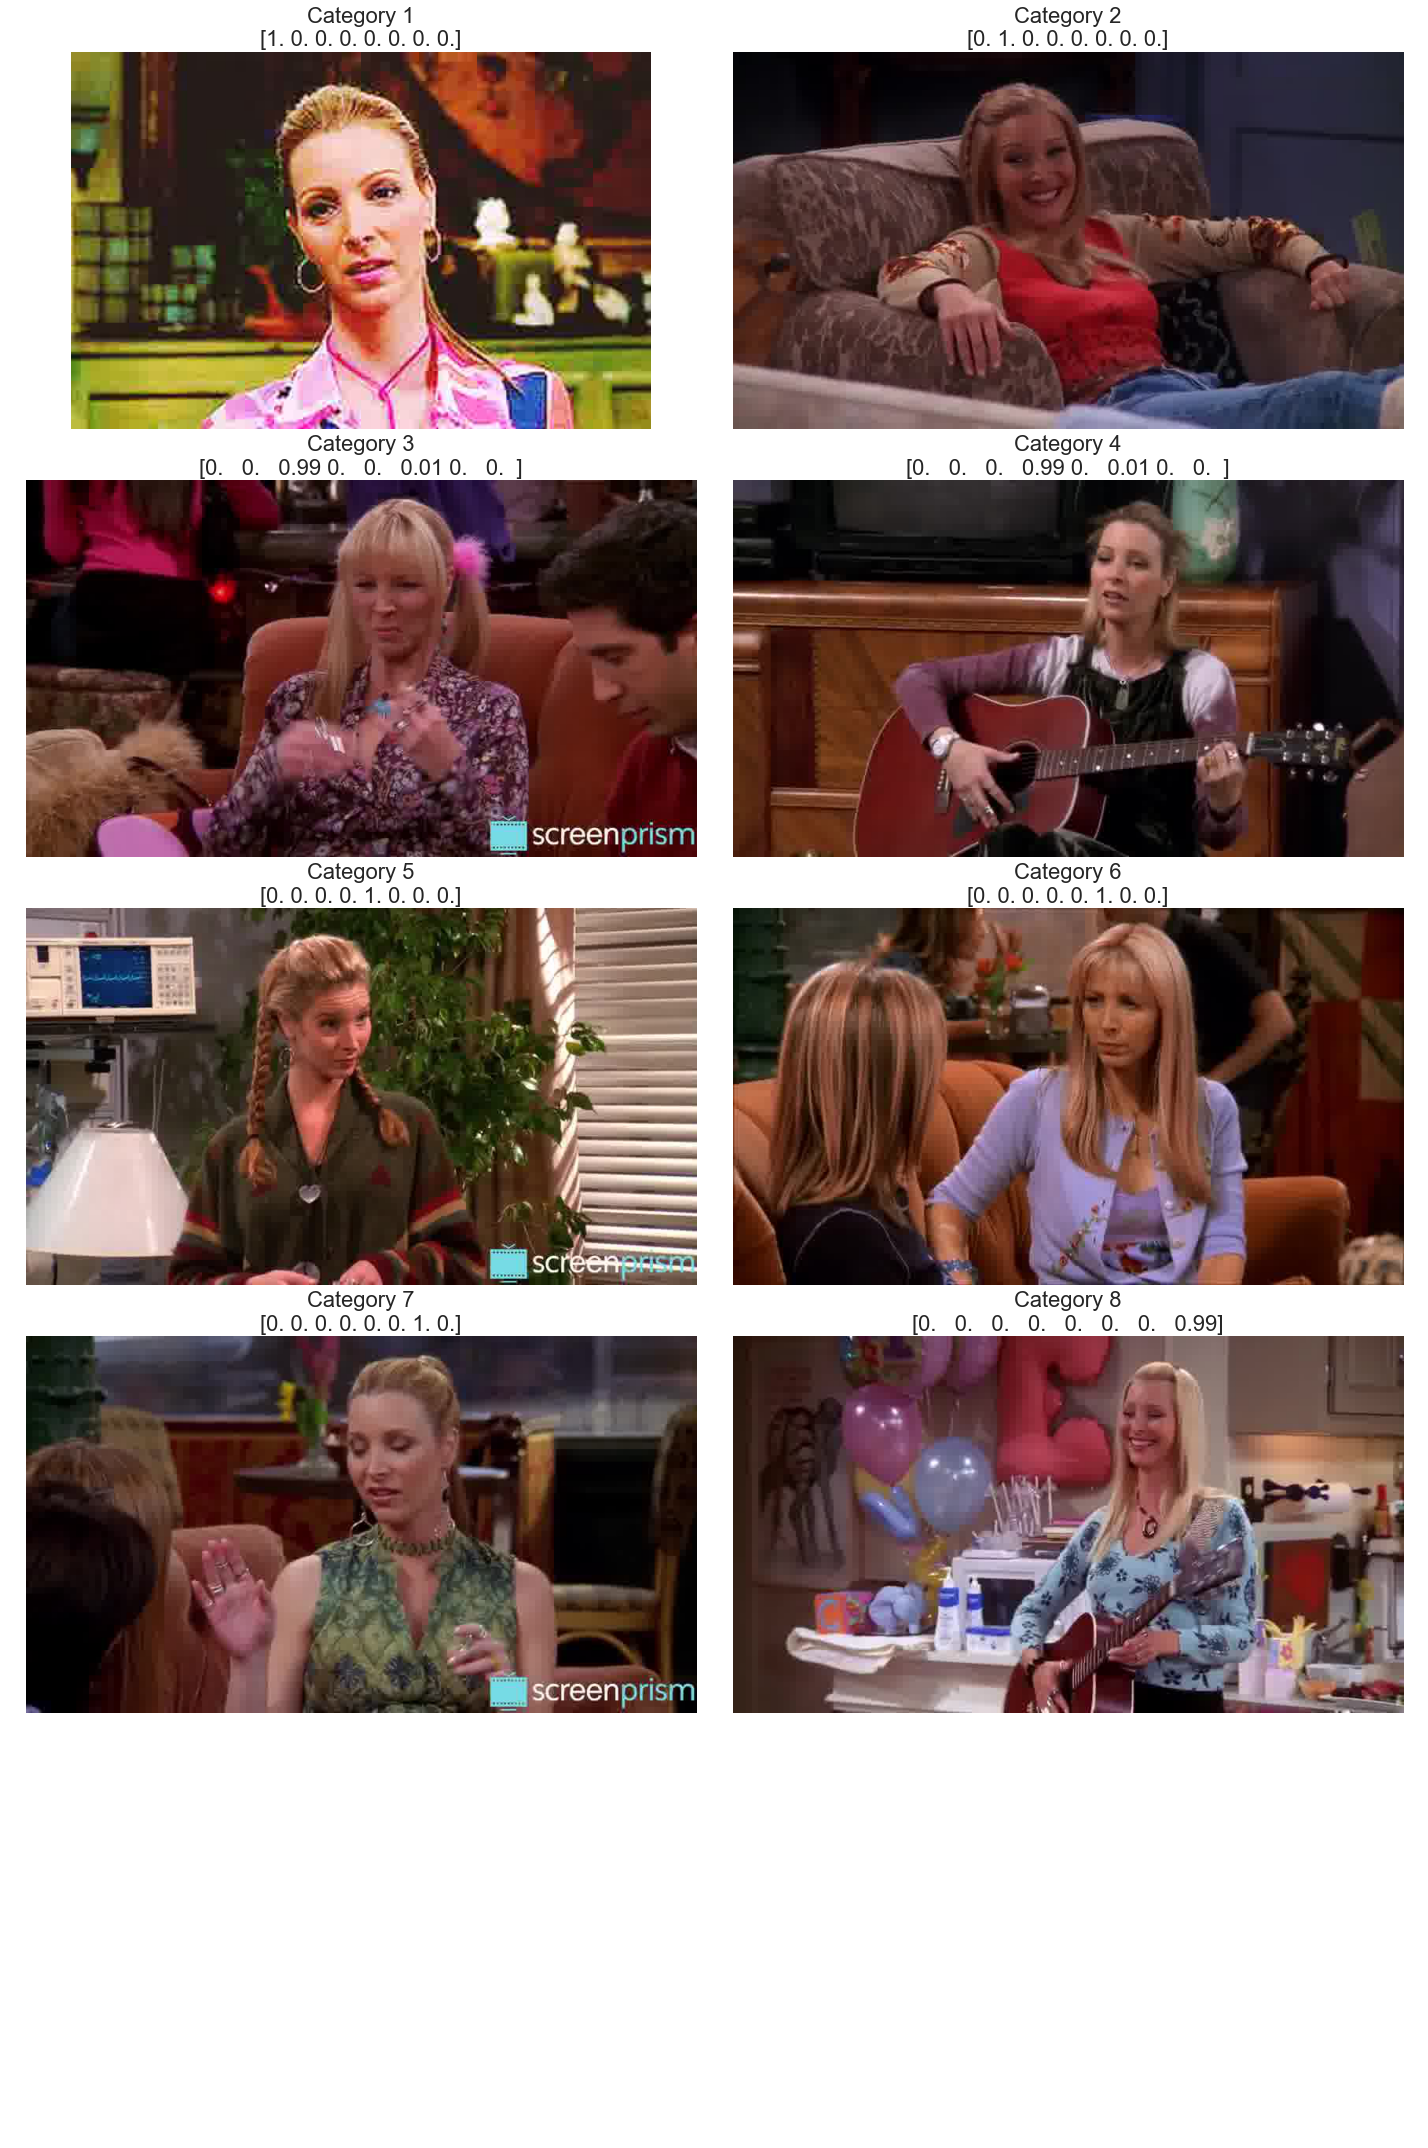

In [25]:
import random

def show_pic_for_probs(probs, num_images=1):
    """
    :param probs: numpy array of probabilities
    :param num_images: number of images to show per category
    """
    
    # Find the row index of the highest value for every column. The row index can be linked back to its image.
    maxval = np.max(probs, axis=0)
    print(f"Max probability for each column: {maxval}\n")

    # Transform to panda dataframe to find rows with highest value for each category
    probs_pd = pd.DataFrame(probs)
    print(f"A couple rows with probabilities for the {probs_pd.shape[1]} categories:")
    print(probs_pd[227:230].round(3))

    # [col, row_num]
    indices: List[Tuple[int]] = []
        
        
        
     
    # Find max value for every column
    for i in range (0, probs_pd.shape[1]):
        # Select a number of images randomly from 'num_try_images' number of images that match the category.
        # The point of doing that is to hopefully get images from different videos, or time frames
        # that are widely apart. TODO: I think there may be a bug here.
        num_images_try = num_images * 1
        indices_for_category = list(np.argpartition(probs_pd[i], -num_images_try)[-num_images_try:])
        for j in random.sample(indices_for_category, num_images):
            indices.append((i, j))
        
    print(f"\nTuple (col_num, row_num) for max prob of every column: \n{indices}\n")
        




    fig, ax_array = plt.subplots(int(len(indices)/2) + 1, 2, figsize=(20, 30))
    axes = ax_array.flatten()
    
    category_num = 1
    count_img_per_category = 0
    for i, ax in enumerate(axes):
        try:
            img_path = image_path_from_index(indices[i][1])
            print(img_path)
            img=mpimg.imread(img_path)
            
            if count_img_per_category >= num_images:
                category_num += 1
                count_img_per_category = 0
            ax.set_title(f"Category {category_num}\n{probs[indices[i][1]]}", fontsize=22)
            count_img_per_category += 1
            
            ax.axis('off')
            ax.grid(b=None)
            ax.imshow(img)
        except IndexError:
            pass
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0.5, w_pad=0.01)
    plt.savefig(f'emotions_{RUN_ID}.png')

show_pic_for_probs(probs, num_images=1)

## Soft Classification

## Plotting helpers

In [26]:
from scipy.interpolate import make_interp_spline, BSpline

# NUM_COMPONENTS
from itertools import cycle
cycol = cycle('bgrcmk')

def line_chart(probs):
    # https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0
    # x is frame number
    # y is prob intensity
    fig, ax = plt.subplots(figsize=(30,10))
    x = [i for i in range(probs.shape[0])]
    
    xnew = np.linspace(0, probs.shape[0], 300) 

    for dimension in range(0, probs.shape[1]):
        spl = make_interp_spline(x, probs[:,dimension], k=3)  # type: BSpline
        power_smooth = spl(xnew)

        plt.plot(xnew, power_smooth)
    ax.legend(['alpha', 'beta'], facecolor='w')
    plt.show()

#     fig, ax = plt.subplots(figsize=(30,10))
    
#     for dimension in range(probs.shape[1]):
#         sns.lineplot(x=[i for i in range(probs.shape[0])], 
#                      y=[i for i in probs[:,dimension]],
#                      color=next(cycol),
#                      ax=ax)
   
#     ax.legend(['alpha', 'beta'], facecolor='w')
#     plt.show()

In [27]:
def pairplot(probs):
    probs_df = pd.DataFrame(probs) 
    sns.pairplot(probs_df)

In [28]:
from math import pi

from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
    
def pie_chart(probs):
    output_file("pie.html")
    
    x = np.mean(probs, axis = 1)
    print(len(x))
    
    category = [num for num in range(1, x.shape[1] + 1)]
    i = iter(x)
    x = dict(zip(category, i))
    print(category)
    print(x)

    data = pd.Series(x).reset_index(name='value').rename(columns={'index':'category'})
    data['angle'] = data['value']/data['value'].sum() * 2*pi
    data['color'] = Category20c[len(x)]

    p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
               tools="hover", tooltips="@country: @value", x_range=(-0.5, 1.0))

    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', legend_field='category', source=data)

    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None

    show(p)

## Plotted data

In [29]:
# %%capture
test_files: List[str] = [f"{PATH_TESTING_CSV}{name}" for 
                             name in os.listdir(f"{PATH_TESTING_CSV}") if 
                             name[-4:] == ".csv"]

def predict(csv: str):
    """Preprocess and predict using previously trained GMM
    :param file_list: list of test csv
    """

    data = load_dataset(csv, train=False)

    X_test = scaled_AU_np_dataset(preprocess(data))

    embedding = reducer.transform(X_test)
    probs = gmm.predict_proba(embedding) 

    # line_chart(probs)
   # pie_chart(probs)
    
    # pairplot(probs):
    # show_pic_for_every_row(data, probs)

    # Plot a pie chart for the average of each video

    # Plot a radar chart for the average of each video

    # Plot an average picture for X pics with the average plots
    
    # Could do another scatterplot matrix

predict(test_files[0])
# Load datasets
full_test_dataset = create_full_dataset(test_files, train=False)

Running command: ffmpeg -i Phoebe_dataset4/videos/test/52.mp4 Phoebe_dataset4/processed_images/052%3d.jpeg -n
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr

In [36]:
predict(test_files[1])

Running command: ffmpeg -i Phoebe_dataset4/videos/test/53.mp4 Phoebe_dataset4/processed_images/053%3d.jpeg -n
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.59)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags=-fno-stack-check --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr

In [31]:
final_test_dataset = preprocess(full_test_dataset)
X_test = scaled_AU_np_dataset(final_test_dataset)

Removed 0 rows with 'success = 0'
Removed 2 rows with 'confidence <= 0.85'
Removed 0 rows with wrong face id (not Phoebe)


In [32]:
# Reduce dimensions of test data. This must be the same operation performed on the train data.
embedding = reducer.transform(X_test)
print(embedding[0:4])

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
embedding.shape

[[10.89  5.35]
 [10.13  6.98]
 [ 9.46  7.01]
 [ 9.38  6.96]]


(79, 2)

In [33]:
# labels = gmm.predict(embedding)
# print(labels)
# size = 60 * probs.max(1) ** 8 # exponent emphasizes differences
# plt.figure(figsize=(14,14))
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=size, cmap='viridis');

### Predictions

In [34]:
CONFIDENCE_LEVEL = 0.70

def show_pic_for_every_row(dataset, probs):
    """Show a picture with a category for every data point
    
    :param dataset: dataset containing metadata to extract image
    :param probs: probabilities of category for every row in dataset
    """
    categories = np.argmax(probs, axis=1)
    
    fig, ax_array = plt.subplots(int(len(dataset)/2) + 1, 2, figsize=(20,330))
    axes = ax_array.flatten()
    
    for i, ax in enumerate(axes):
        try:
            # Add +1 for index of 'image_path_for_row' to account for header in 'dataset'
            img_path = image_path_for_row(dataset[i + 1])
            print(img_path)
            img=mpimg.imread(img_path)

            # Find max prob per row. Print col index.
            if probs[i][categories[i]] >= CONFIDENCE_LEVEL:
                ax.set_title(f"Category {categories[i]}:\n{probs[i]}", fontsize=22)
            else:
                ax.set_title(f"UNKNOWN {probs[i]}", fontsize=22)
            
            ax.axis('off')
            ax.grid(b=None)
            ax.imshow(img)
        except IndexError:
            pass
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
    plt.tight_layout(h_pad=0.5, w_pad=0.01)
    plt.savefig(f'predictions_{RUN_ID}.png')

In [35]:
# probs = gmm.predict_proba(embedding) 
# categories = np.argmax(probs, axis=1)
# print(f"categories: {categories}\n")

# # Print probability for some rows
# print(f"probs[0:10]: \n{probs[0:10]}\n")

# print(f"final_test_dataset[:3]): \n{final_test_dataset[:3]}\n")
      
# show_pic_for_every_row(full_test_dataset, probs)